# Introduction

En vision par ordinateur, l’objectif le plus courant est de classer une image (« chat », « chien », « voiture », etc.). Mais dans de nombreux cas, on cherche plutôt à **comparer** des images entre elles : retrouver des exemples similaires, regrouper des contenus, ou mesurer une proximité visuelle. Pour cela, nous voulons apprendre un espace de représentation (*embedding*) dans lequel les images similaires sont proches et les images différentes sont éloignées.

Dans la première partie de cette série d'article nous entrainerons un réseau siamois avec une *triplet loss* sur CIFAR‑10.

Nous étudierons ensuite la *KoLeo loss*, une régularisation dépendante du contenu du batch qui vise à mieux répartir les embeddings. Cette dépendance rend naturelle la question de l’accumulation de *gradient* (taille de batch effective) : quel impact sur l’entraînement et la qualité des embeddings ?

Nous commençons par décrire le dataset, la construction des triplets et l’évaluation, puis nous comparerons les résultats avec et sans *KoLeo* avant de discuter l’effet de l'accumulation du gradient.

Dans un premier temps, nous fixons les *seeds* pour la reproductibilité.



In [1]:
import numpy as np
import torch

seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(seed)

## Le dataset utilisé

Pour entraîner et évaluer notre modèle, nous utilisons le jeu de données [CIFAR‑10](https://www.cs.toronto.edu/~kriz/cifar.html), un *benchmark* classique composé de 60 000 images couleur (32×32 pixels) réparties en 10 classes équilibrées : airplane, car, bird, cat, deer, dog, frog, horse, ship et truck. Le jeu est initialement séparé en 50 000 exemples d’entraînement et 10 000 exemples de test, mais ici nous n’utilisons que les données d’entraînement.

Après téléchargement, on remarque que l’archive contient 6 fichiers binaires : `data_batch_1` à `data_batch_5` et `test_batch`. Nous n’utiliserons que les fichiers `data_batch_*`.


In [2]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_batch = [unpickle(f"../cifar-10-python/data_batch_{i}") for i in range(1, 6)]
images = np.concatenate([data_batch[i][b'data'] for i in range(5)])
labels = np.concatenate([data_batch[i][b'labels'] for i in range(5)])

images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
images.shape

(50000, 32, 32, 3)

Nous avons donc bien 50 000 images de taille 32×32 en RVB. En voici quelques-unes sélectionnées aléatoirement, avec leur classe.

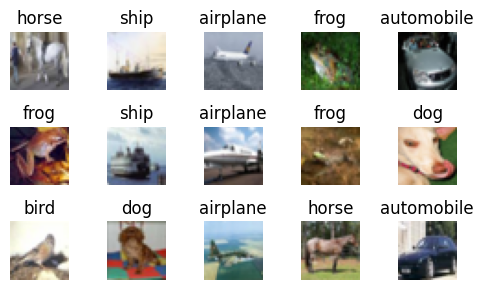

In [3]:
import matplotlib.pyplot as plt

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

n_rows, n_cols = 3, 5
indices = np.random.choice(len(images), n_rows * n_cols, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

for ax, idx in zip(axes.ravel(), indices):
    ax.imshow(images[idx])
    label = label_names[labels[idx]]
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Les réseaux siamois

## Qu’est-ce qu’un réseau siamois ?

Un réseau siamois est une architecture de réseau de neurones conçue non pas pour prédire directement une classe, mais pour **comparer** des exemples entre eux.

L’idée clé est la suivante : deux images que l’on considère comme « similaires » (par exemple deux chiens) doivent être proches dans l’espace de représentation, alors que deux images « différentes » (un chien et une voiture) doivent être éloignées. Pendant l’entraînement, on présente donc au modèle des paires ou des triplets d’images (`ancre`, `positive`, `négative`) et l’on ajuste les poids pour rapprocher `ancre` et `positive`, tout en éloignant `ancre` et `négative`.


![Schéma d'un réseau siamois](images/siamese-scheme-french.png)

Dans la suite, nous détaillerons le modèle utilisé pour produire ces embeddings ainsi que la fonction de coût (la *triplet loss*) qui formalise cette notion de similarité.

## VGG11

VGG11 est une architecture de réseau de neurones convolutifs proposée en 2014 par une équipe de l’université d’Oxford (Simonyan et Zisserman). L’idée majeure de la famille de réseau VGG est d’empiler de nombreux petits filtres convolutifs 3×3, séparés par des couches de *pooling*, plutôt que d’utiliser quelques grandes convolutions. Cela permet d’augmenter la profondeur du réseau tout en gardant une structure très régulière. Nous partirons de cette architecture pré‑entraînée sur ImageNet et nous l’adapterons pour produire des embeddings.

![VGG11](images/vgg11-model.png)

Voyons d’abord la taille du tenseur en sortie de VGG11.

In [4]:
from torchvision import models

vgg = models.vgg11(pretrained=False)

sample = images[0]                              
x = torch.from_numpy(sample).permute(2, 0, 1)
x = x.unsqueeze(0).float() / 255.0

with torch.no_grad():
    out = vgg(x)

print("Taille du tenseur en sortie de VGG11 :", out.shape)

/Users/adlane/perso/koleo/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adlane/perso/koleo/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Taille du tenseur en sortie de VGG11 : torch.Size([1, 1000])


La taille `(1, 1000)` signifie que, pour une image d’entrée, VGG11 renvoie un vecteur de 1 000 composantes. Ce nombre vient directement de la couche linéaire finale du modèle d’origine (`FC-1000` puis `Softmax` sur le schéma) : VGG11 a été conçu pour attribuer une classe parmi 1000 à chaque image. Sa dernière couche produit donc un vecteur de 1 000 scores contenant les probabilités d'appartenance pour toutes les classes.

Dans notre cas, nous n’utiliserons pas ce vecteur. Nous utiliserons la sortie de la dernière couche de convolution, accessible via `vgg.features`.

Quelle est la taille du tenseur juste après la dernière couche de convolution ?

In [5]:
with torch.no_grad():
    out = vgg.features(x)

print("Taille du tenseur en sortie de la dernière couche de convolution de VGG11 :", out.shape)

Taille du tenseur en sortie de la dernière couche de convolution de VGG11 : torch.Size([1, 512, 1, 1])


On obtient un tenseur de forme `(512, 1, 1)`.

- `512` correspond au nombre de cartes de caractéristiques (*features*) produites par la dernière couche de convolution : 512 canaux décrivant l’image.
- `(1, 1)` correspond aux dimensions spatiales, réduites à 1×1 par la succession de convolutions et de *pooling*. Chaque canal résume donc l’image en une seule valeur avant de passer aux couches *fully connected*.

L’entrée de la couche linéaire a donc une dimension \(512 x 1 x 1 = 512\). Pour obtenir un vecteur d'embedding plus compact, nous projetons ensuite en dimension 128 via une couche linéaire. Enfin, nous ajoutons une couche de normalisation en sortie, utile pour les comparaisons entre embeddings.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class VGG11Embedding(nn.Module):
    def __init__(self, pretrained):
        super(VGG11Embedding, self).__init__()
        vgg = models.vgg11(pretrained=pretrained)
        self.features = vgg.features
        self.linear = nn.Linear(512, 128)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = F.normalize(x, p=2, dim=1)
        return x

Vérifions la taille en sortie de notre modèle :

In [7]:
vgg_embedding = VGG11Embedding(pretrained=False)

with torch.no_grad():
    out = vgg_embedding(x)

print("Taille du tenseur en sortie de notre modèle :", out.shape)

Taille du tenseur en sortie de notre modèle : torch.Size([1, 128])


Nous avons donc bien un embedding de taille 128.

## La *triplet loss*

L’objectif de la *triplet loss* est d’imposer une structure géométrique à l’espace des embeddings : pour chaque triplet d’images (`ancre`, `positive`, `négative`), on veut que l’embedding de `positive` soit plus proche de celui de `ancre` que ne l’est celui de `négative`, avec une certaine marge. Autrement dit, on cherche à vérifier
$$ d(f(a), f(p)) + m < d(f(a), f(n)) $$
où \\(f(\cdot)\\) est le réseau d’embedding, \\(d\\) une mesure de distance  et \\(m > 0\\) la marge.


Dans notre cas, nous utilisons une distance dérivée de la similarité cosinus : plus deux vecteurs sont proches angulairement, plus ils sont considérés comme similaires. La *triplet loss* s’écrit alors, pour un batch de taille \\(B\\),
$$ \mathcal{L} = \frac{1}{B} \sum_{i=1}^B \max\big(0,\ d(a_i, p_i) - d(a_i, n_i) + m\big). $$

Chaque terme est nul dès que la contrainte est satisfaite (le triplet est « bon »). La valeur est strictement positive lorsque `ancre` est encore trop proche de `négative`. On ne veut donc pas seulement \\(d(a_i, p_i) < d(a_i, n_i)\\), mais une séparation d’au moins \\(m\\).

In [8]:
def triplet_loss(anchor, positive, negative, margin=0.4):
    positive_distances = 1 - F.cosine_similarity(anchor, positive, dim=1)
    negative_distances = 1 - F.cosine_similarity(anchor, negative, dim=1)
    loss = torch.clamp(positive_distances - negative_distances + margin, min=0)
    return loss.mean()

## Construction des triplets

Pour entraîner un réseau siamois avec une *triplet loss*, nous devons transformer notre dataset d’images indépendantes en un dataset de triplets (`ancre`, `positive`, `négative`). Sur CIFAR‑10, nous procédons classe par classe :
- pour une classe donnée (par exemple « chat »), nous formons des paires (`ancre`, `positive`) avec deux images de cette classe ;
- nous tirons ensuite au hasard une image d’une classe différente pour jouer le rôle de `négative`.

On répète cette opération pour chacune des 10 classes, ce qui donne un ensemble de triplets globalement équilibré. Le code ci‑dessous construit ces triplets à partir des tableaux `images` et `labels` et nous échantillonnons le nombre d’images `négatives` à 2 500.

In [9]:
triplets = np.empty((0, 3, 32, 32, 3), dtype=np.uint8)
triplets_labels = np.empty((0, 3), dtype=np.uint8)

set_seed(seed)
for target in range(10):
    class_mask = (labels == target)
    images_target = images[class_mask]
    labels_target = labels[class_mask]

    pairs = images_target.reshape(-1, 2, 32, 32, 3)
    pos_labels = np.ones((len(pairs), 2), dtype=np.uint8) * target

    not_target_mask = (labels != target)
    images_not_target = images[not_target_mask]
    labels_not_target = labels[not_target_mask]

    # On echantillonne un nombre fixe de negatives pour cette classe
    n_neg = min(2500, len(images_not_target))
    neg_indices = np.random.choice(len(images_not_target), n_neg, replace=False)
    negatives = images_not_target[neg_indices]
    neg_labels = labels_not_target[neg_indices]

    pairs = pairs[:n_neg]
    pos_labels = pos_labels[:n_neg]

    class_triplets = np.concatenate(
        [pairs, negatives.reshape(n_neg, 1, 32, 32, 3)],
        axis=1,
    )
    class_triplet_labels = np.concatenate(
        [pos_labels, neg_labels.reshape(n_neg, 1)],
        axis=1,
    )

    triplets = np.concatenate([triplets, class_triplets], axis=0)
    triplets_labels = np.concatenate([triplets_labels, class_triplet_labels], axis=0)

triplets.shape, triplets_labels.shape

((25000, 3, 32, 32, 3), (25000, 3))

### La classe `TripletsCIFAR10Dataset` et la visualisation des triplets

Pour faciliter l’entraînement, nous encapsulons ces triplets dans un `Dataset` dédié. Le tenseur de triplets est converti au format `(N, 3, C, H, W)` puis, à chaque appel, on renvoie les trois images (`ancre`, `positive`, `négative`).

In [10]:
from torch.utils.data import Dataset
import torchvision.transforms as T

class TripletsCIFAR10Dataset(Dataset):
    def __init__(self, triplets, transform=None):
        # (N, 3, H, W, C) -> (N, 3, C, H, W)
        self.triplets = torch.from_numpy(
            triplets.transpose(0, 1, 4, 2, 3) / 255.0
        ).float()
        self.transform = transform

    def __len__(self):
        return self.triplets.shape[0]

    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        anchor, positive, negative = triplet[0], triplet[1], triplet[2]
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

train_transforms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

val_transforms = T.Compose([
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

triplet_dataset = TripletsCIFAR10Dataset(triplets)

Visualisons une sélection aléatoire de triplets.


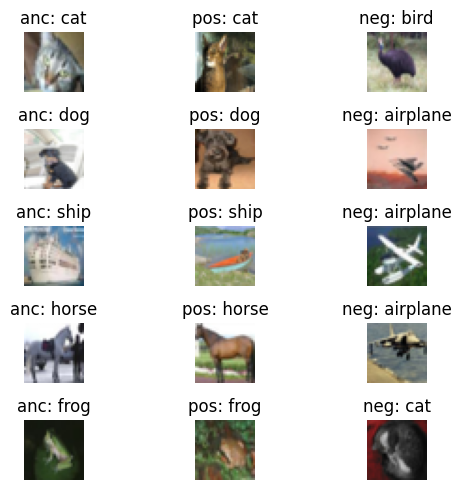

In [11]:
n_examples = 5
indices = np.random.choice(len(triplet_dataset), n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 3, figsize=(6, 1 * n_examples))

for row_idx, idx in enumerate(indices):
    anchor, positive, negative = triplet_dataset[idx]

    anchor_img = anchor.permute(1, 2, 0).numpy()
    positive_img = positive.permute(1, 2, 0).numpy()
    negative_img = negative.permute(1, 2, 0).numpy()

    anchor_label = int(triplets_labels[idx, 0])
    positive_label = int(triplets_labels[idx, 1])
    negative_label = int(triplets_labels[idx, 2])

    axes[row_idx, 0].imshow(anchor_img)
    axes[row_idx, 0].set_title(f'anc: {label_names[anchor_label]}', fontsize=12)
    axes[row_idx, 0].axis('off')
    axes[row_idx, 0].set_ylabel(f'Triplet {idx}', fontsize=12, rotation=0, labelpad=50)

    axes[row_idx, 1].imshow(positive_img)
    axes[row_idx, 1].set_title(f'pos: {label_names[positive_label]}', fontsize=12)
    axes[row_idx, 1].axis('off')

    axes[row_idx, 2].imshow(negative_img)
    axes[row_idx, 2].set_title(f'neg: {label_names[negative_label]}', fontsize=12)
    axes[row_idx, 2].axis('off')

plt.tight_layout()
plt.show()

## L’entraînement

### Paramètres de l’entraînement

Pour entraîner notre réseau siamois avec la *triplet loss*, nous devons choisir quelques hyperparamètres clés :
- la **taille de batch** ;
- le **taux d’apprentissage** de l’optimiseur ;
- le **nombre d’epochs** ;
- la **marge** de la *triplet loss*.

Nous définissons également le `device` et choisissons Adam comme optimiseur.

In [12]:
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

batch_size = 64
learning_rate = 5e-4
margin = 0.4

net = VGG11Embedding(pretrained=True).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

/Users/adlane/perso/koleo/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Métriques d’évaluation

Nous utilisons les métriques suivantes pour évaluer le modèle sur la phase de validation :
- **ratio de « bons » triplets** : proportion de triplets où `ancre` est plus proche de `positive` que de `négative` ;
- **similarités cosinus moyennes** `ancre`–`positive` et `ancre`–`négative` ;
- **distances euclidiennes moyennes** `ancre`–`positive` et `ancre`–`négative` ;
- **AUC**.

#### AUC (*Area Under the Curve*)

L’AUC est l’aire sous la courbe ROC (*Receiver Operating Characteristic*), qui trace le taux de vrais positifs en fonction du taux de faux positifs pour tous les seuils possibles. Elle mesure la capacité du modèle à ordonner correctement les exemples : concrètement, c’est la probabilité qu’un exemple positif reçoive une similarité plus élevée qu’un exemple négatif. Une AUC de 0,5 correspond à un classement au hasard, tandis qu’une AUC de 1 indique une séparation parfaite.

Dans notre contexte, le réseau produit des embeddings (et non des probabilités de classe). Pour calculer l’AUC, on se ramène à une tâche binaire paire-à-paire : on considère (`ancre`, `positive`) comme paire positive (label 1) et (`ancre`, `négative`) comme paire négative (label 0). La similarité cosinus entre embeddings sert de score, et l’AUC résume à quel point le modèle attribue des similarités plus élevées aux paires de même classe.

### Boucle d’entraînement

La boucle d’entraînement parcourt le `DataLoader` de triplets, calcule les embeddings `(f(a), f(p), f(n))` pour chaque batch, évalue la *triplet loss*, puis effectue une étape de rétropropagation et de mise à jour des poids. Nous calculons également la *loss* moyenne par epoch et affichons périodiquement la *loss* courante pour suivre la convergence.

In [13]:
def train_loop(net, dataloader, optimizer, margin, print_freq=10):
    net.train()
    loss_accum = 0.0
    epoch_loss = 0.0
    for batch_idx, (anc, pos, neg) in enumerate(dataloader):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

        loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += loss.item()
        epoch_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Batch {batch_idx+1} : loss = {loss_accum / print_freq:.4f}")
            loss_accum = 0.0

    return epoch_loss / (batch_idx + 1)

### Boucle de validation

Pour tout l'ensemble de validation, nous calculons les métriques définies plus haut (similarités cosinus, distances euclidiennes, ratio de bons triplets et AUC).

In [14]:
from sklearn.metrics import roc_auc_score

def validation_loop(net, dataloader, margin):
    net.eval()
    val_loss = 0.0
    good_triplets = 0
    total_triplets = 0

    positive_similarities = []
    negative_similarities = []
    positive_euclidean_distances = []
    negative_euclidean_distances = []

    with torch.no_grad():
        for batch_idx, (anc, pos, neg) in enumerate(dataloader):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

            loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            val_loss += loss.item()

            batch_pos_euc = F.pairwise_distance(anc_feat, pos_feat, p=2)
            batch_neg_euc = F.pairwise_distance(anc_feat, neg_feat, p=2)
            positive_euclidean_distances.append(batch_pos_euc)
            negative_euclidean_distances.append(batch_neg_euc)

            batch_pos_sim = F.cosine_similarity(anc_feat, pos_feat, dim=1)
            batch_neg_sim = F.cosine_similarity(anc_feat, neg_feat, dim=1)
            positive_similarities.append(batch_pos_sim)
            negative_similarities.append(batch_neg_sim)

            good_triplets += (batch_pos_sim > batch_neg_sim).sum()
            total_triplets += anc.shape[0]

    positive_euclidean_distances = torch.cat(positive_euclidean_distances, dim=0)
    negative_euclidean_distances = torch.cat(negative_euclidean_distances, dim=0)
    positive_similarities = torch.cat(positive_similarities, dim=0)
    negative_similarities = torch.cat(negative_similarities, dim=0)

    scores = torch.cat([positive_similarities, negative_similarities], dim=0)
    targets = torch.cat([
        torch.ones_like(positive_similarities),
        torch.zeros_like(negative_similarities)
    ], dim=0)

    val_auc = roc_auc_score(targets.cpu().numpy(), scores.cpu().numpy())

    return {
        "val_loss": val_loss / (batch_idx + 1),
        "val_auc": val_auc,
        "mean_positive_similarities": positive_similarities.mean().item(),
        "mean_negative_similarities": negative_similarities.mean().item(),
        "mean_positive_euclidean_distances": positive_euclidean_distances.mean().item(),
        "mean_negative_euclidean_distances": negative_euclidean_distances.mean().item(),
        "good_triplets_ratio": (good_triplets / total_triplets).item(),
    }

### Entraînement complet sur plusieurs epochs

Pour entraîner un modèle, il nous faut construire nos `DataLoader` d’entraînement et de validation :

In [15]:
from torch.utils.data import DataLoader

val_split = 0.05
num_train = int((1 - val_split) * len(triplets))

shuffle_indices = np.random.permutation(len(triplets))
triplets = triplets[shuffle_indices]
triplets_labels = triplets_labels[shuffle_indices]

train_triplets = triplets[:num_train, ...]
val_triplets = triplets[num_train:]
train_labels = triplets_labels[:num_train, ...]
val_labels = triplets_labels[num_train:]

train_dataset = TripletsCIFAR10Dataset(train_triplets, transform=train_transforms)
val_dataset = TripletsCIFAR10Dataset(val_triplets, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Nous pouvons maintenant écrire la boucle d’entraînement complète : à chaque epoch, nous entraînons le modèle sur les triplets d’entraînement, puis nous calculons les métriques sur la validation.

Pour faciliter les expérimentations, nous sauvegardons régulièrement les poids. Nous sauvegardons également la configuration et les métriques de validation dans le dossier de l’expérience courante.

In [16]:
from datetime import datetime
import json
from pathlib import Path

runs_dir = Path('runs')
runs_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = runs_dir / timestamp
save_dir.mkdir(exist_ok=True)

epochs = 15
save_ckpt_freq = 1

with (save_dir / "config.json").open("w") as fp:
    json.dump({
        "seed": seed,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "margin": margin,
        "val_split": val_split,
        "num_train": num_train,
        "save_ckpt_freq": save_ckpt_freq
    }, fp, indent=4)

In [17]:
import csv

metrics_path = save_dir / "training_metrics.csv"

train_losses = []
val_losses = []
best_auc = 0
best_epoch_path = None

csv_headers = [
    "epoch",
    "train_loss",
    "val_loss",
    "val_auc",
    "mean_positive_similarities",
    "mean_negative_similarities",
    "mean_positive_euclidean_distances",
    "mean_negative_euclidean_distances",
    "good_triplets_ratio"
]

with open(metrics_path, mode='w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    writer.writeheader()

set_seed(seed)

val_metrics = validation_loop(net, val_loader, margin)
print(f"Avant entraînement, epoch 0 — val_loss = {val_metrics['val_loss']}")
print(
    f"Métriques de validation — "
    f"val_loss: {val_metrics['val_loss']:.4f}, "
    f"val_auc: {val_metrics['val_auc']:.4f}, "
    f"mean_positive_similarities: {val_metrics['mean_positive_similarities']:.4f}, "
    f"mean_negative_similarities: {val_metrics['mean_negative_similarities']:.4f}, "
    f"mean_positive_euclidean_distances: {val_metrics['mean_positive_euclidean_distances']:.4f}, "
    f"mean_negative_euclidean_distances: {val_metrics['mean_negative_euclidean_distances']:.4f}, "
    f"good_triplets_ratio: {val_metrics['good_triplets_ratio']:.4f}"
)
with open(metrics_path, mode='a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    writer.writerow({
        "epoch": 0,
        "train_loss": "",  # No train_loss before training
        "val_loss": val_metrics['val_loss'],
        "val_auc": val_metrics['val_auc'],
        "mean_positive_similarities": val_metrics['mean_positive_similarities'],
        "mean_negative_similarities": val_metrics['mean_negative_similarities'],
        "mean_positive_euclidean_distances": val_metrics['mean_positive_euclidean_distances'],
        "mean_negative_euclidean_distances": val_metrics['mean_negative_euclidean_distances'],
        "good_triplets_ratio": val_metrics['good_triplets_ratio']
    })

for epoch_idx in range(epochs):
    train_loss = train_loop(net, train_loader, optimizer, margin, print_freq=100)
    val_metrics = validation_loop(net, val_loader, margin)
    val_losses.append(val_metrics['val_loss'])
    train_losses.append(train_loss if epoch_idx > 0 else val_metrics['val_loss'])

    print(
        f"Époque {epoch_idx+1} — "
        f"train_loss = {train_loss:.4f}, "
        f"val_loss = {val_metrics['val_loss']:.4f}"
    )
    print(
        f"Métriques de validation — "
        f"val_loss: {val_metrics['val_loss']:.4f}, "
        f"val_auc: {val_metrics['val_auc']:.4f}, "
        f"mean_positive_similarities: {val_metrics['mean_positive_similarities']:.4f}, "
        f"mean_negative_similarities: {val_metrics['mean_negative_similarities']:.4f}, "
        f"mean_positive_euclidean_distances: {val_metrics['mean_positive_euclidean_distances']:.4f}, "
        f"mean_negative_euclidean_distances: {val_metrics['mean_negative_euclidean_distances']:.4f}, "
        f"good_triplets_ratio: {val_metrics['good_triplets_ratio']:.4f}"
    )

    with open(metrics_path, mode='a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        writer.writerow({
            "epoch": epoch_idx + 1,
            "train_loss": train_loss,
            "val_loss": val_metrics['val_loss'],
            "val_auc": val_metrics['val_auc'],
            "mean_positive_similarities": val_metrics['mean_positive_similarities'],
            "mean_negative_similarities": val_metrics['mean_negative_similarities'],
            "mean_positive_euclidean_distances": val_metrics['mean_positive_euclidean_distances'],
            "mean_negative_euclidean_distances": val_metrics['mean_negative_euclidean_distances'],
            "good_triplets_ratio": val_metrics['good_triplets_ratio']
        })

    if val_metrics['val_auc'] > best_auc:
        best_auc = val_metrics['val_auc']
        if best_epoch_path is not None:
            best_epoch_path.unlink()
        best_epoch_path = save_dir / f'best_epoch_{epoch_idx+1}.pth'
        torch.save(net.state_dict(), best_epoch_path)
        print(f"Nouvelle meilleure AUC : {best_auc:.4f} (epoch {epoch_idx+1})")

    if (epoch_idx+1) % save_ckpt_freq == 0:
        torch.save(net.state_dict(), save_dir / f'epoch_{epoch_idx+1}.pth')

Avant entraînement, epoch 0 — val_loss = 0.3092861518263817
Métriques de validation — val_loss: 0.3093, val_auc: 0.6764, mean_positive_similarities: 0.2754, mean_negative_similarities: 0.1793, mean_positive_euclidean_distances: 1.1962, mean_negative_euclidean_distances: 1.2766, good_triplets_ratio: 0.6928
Batch 100 : loss = 0.2213
Batch 200 : loss = 0.1943
Batch 300 : loss = 0.1630
Époque 1 — train_loss = 0.1872, val_loss = 0.1577
Métriques de validation — val_loss: 0.1577, val_auc: 0.8403, mean_positive_similarities: 0.7603, mean_negative_similarities: 0.2158, mean_positive_euclidean_distances: 0.5773, mean_negative_euclidean_distances: 1.1755, good_triplets_ratio: 0.8352
Nouvelle meilleure AUC : 0.8403 (epoch 1)
Batch 100 : loss = 0.1443
Batch 200 : loss = 0.1411
Batch 300 : loss = 0.1389
Époque 2 — train_loss = 0.1381, val_loss = 0.1381
Métriques de validation — val_loss: 0.1381, val_auc: 0.8643, mean_positive_similarities: 0.7282, mean_negative_similarities: 0.1812, mean_positive_e

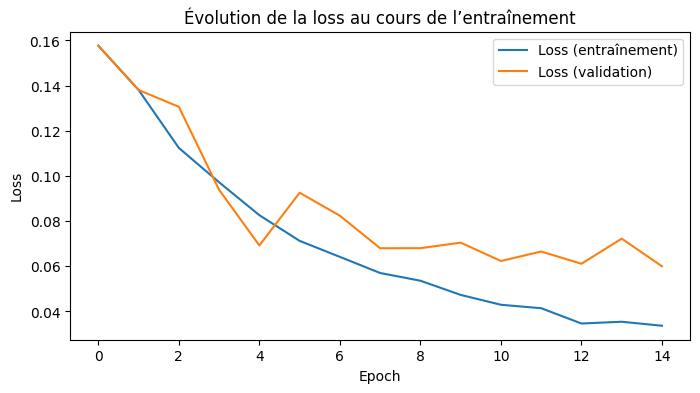

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Loss (entraînement)")
plt.plot(val_losses, label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution de la loss au cours de l’entraînement")
plt.show()

### Visualisation de la courbe ROC et de l’AUC

Pour mieux interpréter les performances du modèle, nous traçons la courbe ROC (*Receiver Operating Characteristic*), qui représente le taux de vrais positifs en fonction du taux de faux positifs pour tous les seuils possibles. L’aire sous cette courbe (AUC) résume en un seul nombre la capacité du modèle à séparer les paires de même classe des paires de classes différentes.

Nous utilisons les données de validation pour construire cette courbe : les paires (`ancre`, `positive`) sont considérées comme positives (label 1) et les paires (`ancre`, `négative`) comme négatives (label 0). La similarité cosinus entre embeddings sert de score.

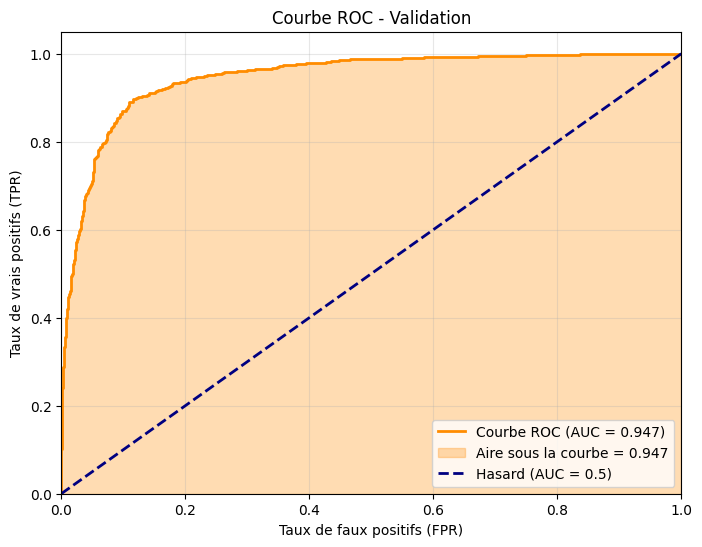

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

net.eval()
positive_similarities = []
negative_similarities = []

with torch.no_grad():
    for batch_idx, (anc, pos, neg) in enumerate(val_loader):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)
        
        batch_pos_sim = F.cosine_similarity(anc_feat, pos_feat, dim=1)
        batch_neg_sim = F.cosine_similarity(anc_feat, neg_feat, dim=1)
        positive_similarities.append(batch_pos_sim)
        negative_similarities.append(batch_neg_sim)

positive_similarities = torch.cat(positive_similarities, dim=0)
negative_similarities = torch.cat(negative_similarities, dim=0)

scores = torch.cat([positive_similarities, negative_similarities], dim=0).cpu().numpy()
targets = torch.cat([
    torch.ones_like(positive_similarities),
    torch.zeros_like(negative_similarities)
], dim=0).cpu().numpy()

fpr, tpr, thresholds = roc_curve(targets, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange', label=f'Aire sous la courbe = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Validation')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Ici, nous ajoutons du code pour recharger le modèle si quelque chose se passe mal dans la suite du notebook.

In [20]:
# save_dir = Path("runs/20251213_224845")
# net.load_state_dict(torch.load(save_dir / 'best_epoch_2.pth'))

# Conclusion

Dans cette première partie, nous avons présenté l'entraînement d'un réseau siamois sur CIFAR‑10 avec une *triplet loss*. Nous avons détaillé la construction du dataset de triplets, l'architecture du modèle basée sur VGG11, et la boucle d'entraînement complète avec ses métriques d'évaluation. L'entraînement montre une convergence satisfaisante avec une loss qui décroît régulièrement et des métriques de validation qui s'améliorent d'epoch en epoch.

Dans la suite de cette série, nous analyserons les embeddings obtenus en visualisant les résultats, puis nous introduirons la *KoLeo loss* pour encourager une répartition plus uniforme des embeddings, et nous étudierons l'impact de l'accumulation de *gradient* sur cette régularisation dépendante du batch.

########################################################

Dans le précédent chapitre nous avons entraîné notre premier modèle siamois. Il fonctionne car la loss de validation décroit sur les premières epochs. De plus les métriques de validation s'améliorent d'epoch en epoch. Ce sont d'excellents signes que l'apprentissage s'est bien passé. Nous allons pouvoir commencer à analyser nos embeddings, d'une part avec la matrice de distances, et d'autre part à l'aide d'une ACP.

# Matrice de distances

On peut déjà comparer les distances entre `ancre` et `positive`, et celles entre `ancre` et `négative`. Les premières devraient être **plus petites** que les secondes.

Une façon de le vérifier est de construire une matrice 10×10 où chaque case \((i, j)\) contient la distance moyenne (ici dérivée de la similarité cosinus) entre les embeddings des images de la classe \(i\) et ceux de la classe \(j\). Sur la diagonale, on retrouve les distances intra‑classe (qui devraient être faibles si le modèle regroupe bien les images similaires). Une *heatmap* permet de visualiser rapidement la qualité de la séparation apprise.

Pour calculer cette matrice, nous commençons par construire un dictionnaire contenant les embeddings du jeu de validation, regroupés par classe.

In [21]:
net.eval()

embeddings_by_class = {i: [] for i in range(10)} 

with torch.no_grad():
    anchor_labels = val_labels[:, 0]
    
    for idx in range(len(val_triplets)):
        label = int(anchor_labels[idx])
        
        img = torch.from_numpy(val_triplets[idx, 0].transpose(2, 0, 1) / 255.0).float()
        img = val_transforms(img)
        img = img.unsqueeze(0).to(device)
        
        embedding = net(img)
        embeddings_by_class[label].append(embedding.cpu())

embeddings_by_class = {label: torch.cat(embeddings_by_class[label], dim=0) for label in range(10)}
samples_per_class = [len(embeddings_by_class[i]) for i in range(10)]

print("Nombre d'embeddings par classe :")
for class_idx, count in enumerate(samples_per_class):
    print(f"  {label_names[class_idx]:10s} : {count}")

Nombre d'embeddings par classe :
  airplane   : 124
  automobile : 113
  bird       : 125
  cat        : 119
  deer       : 127
  dog        : 138
  frog       : 119
  horse      : 123
  ship       : 130
  truck      : 132


In [22]:
dist_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        emb_i = embeddings_by_class[i]
        emb_j = embeddings_by_class[j]
        
        emb_i_norm = F.normalize(emb_i, p=2, dim=1)
        emb_j_norm = F.normalize(emb_j, p=2, dim=1)
        
        cosine_sim = torch.mm(emb_i_norm, emb_j_norm.t())
        cosine_dist = 1 - cosine_sim
        
        dist_matrix[i, j] = cosine_dist.mean().item()

print(f"Dimension de la matrice des distances : {dist_matrix.shape}")
dist_matrix

Dimension de la matrice des distances : (10, 10)


array([[0.16124831, 1.16584909, 0.75517124, 1.17487168, 1.03120434,
        1.21735156, 1.2835449 , 1.10404694, 0.74637926, 1.11012316],
       [1.16584909, 0.21340227, 1.45904374, 1.32663393, 1.41936672,
        1.32318223, 1.10714138, 1.36428154, 0.87585449, 0.65769845],
       [0.75517124, 1.45904398, 0.37313449, 0.84418499, 0.85241681,
        0.91793299, 0.9647814 , 0.9812752 , 1.11957252, 1.30334067],
       [1.17487168, 1.32663393, 0.84418499, 0.26312363, 0.74529028,
        0.36305472, 0.69436389, 0.7757206 , 1.17979074, 1.11703753],
       [1.03120446, 1.41936672, 0.85241681, 0.74529022, 0.23155765,
        0.78006458, 0.97499228, 0.70315397, 1.27855551, 1.28345919],
       [1.21735156, 1.32318223, 0.91793299, 0.36305469, 0.78006452,
        0.29617718, 0.87353909, 0.69927227, 1.25501871, 1.17946184],
       [1.2835449 , 1.10714138, 0.9647814 , 0.69436389, 0.97499228,
        0.87353909, 0.23015089, 1.19163358, 1.15588987, 1.17585552],
       [1.10404682, 1.36428154, 0.9812752

Heatmap enregistrée dans runs/20251216_220611/distance_matrix_heatmap.png


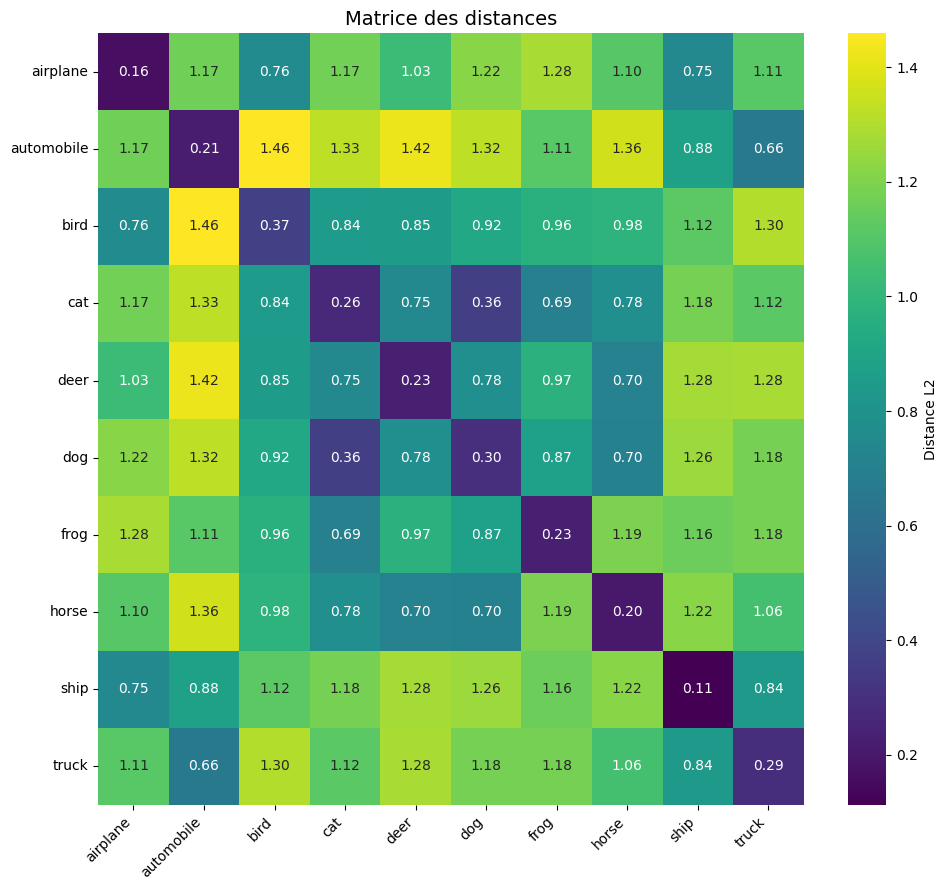


Distances intra-classe : moyenne=0.2367, écart-type=0.0698
Distances inter-classe : moyenne=1.0365, écart-type=0.2422
Marge de séparation : 0.7998


In [23]:
import seaborn as sns

plt.figure(figsize=(10, 9))

col_labels = [f"{label_names[i]}" for i in range(10)]
row_labels = [f"{label_names[i]}" for i in range(10)]

sns.heatmap(dist_matrix, 
            xticklabels=col_labels, 
            yticklabels=row_labels,
            annot=True,
            fmt='.2f',
            cmap='viridis', 
            cbar_kws={'label': 'Distance L2'})

plt.title('Matrice des distances', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plot_filename = save_dir / "distance_matrix_heatmap.png"
plt.savefig(plot_filename)
print(f"Heatmap enregistrée dans {plot_filename}")

plt.show()
plt.close()

same_class_dists = np.diag(dist_matrix)
diff_class_dists = []
for i in range(10):
    for j in range(10):
        if i != j:
            diff_class_dists.append(dist_matrix[i, j])

print(f"\nDistances intra-classe : moyenne={np.mean(same_class_dists):.4f}, écart-type={np.std(same_class_dists):.4f}")
print(f"Distances inter-classe : moyenne={np.mean(diff_class_dists):.4f}, écart-type={np.std(diff_class_dists):.4f}")
print(f"Marge de séparation : {np.mean(diff_class_dists) - np.mean(same_class_dists):.4f}")

Plusieurs observations intéressantes ressortent de cette matrice :

**Diagonale faible** : les distances intra‑classe (sur la diagonale) sont toutes inférieures à 0,4, ce qui montre que le modèle regroupe bien les images d'une même classe. Les classes les mieux regroupées sont *ship* (0,11) et *airplane* (0,16).

**Bonne séparation globale** : la marge de séparation (différence entre la distance inter‑classe moyenne et la distance intra‑classe moyenne) est d'environ 0,80, ce qui est un bon signe.

**Confusions sémantiques attendues** : certaines paires de classes restent relativement proches, ce qui correspond à des similarités visuelles réelles :
   - *cat* et *dog* (0,36) : deux animaux à fourrure de taille similaire ;
   - *airplane* et *ship* (0,75) : véhicules aux formes allongées, avec des arrière‑plans souvent uniformes (ciel/eau) ;
   - *automobile* et *truck* (0,66) : véhicules routiers partageant des caractéristiques visuelles communes.

**Classes bien séparées** : à l'inverse, *automobile* vs *deer* (1,42) ou *bird* vs *truck* (1,20) présentent des distances élevées, cohérentes avec l'absence de ressemblance visuelle entre ces catégories.

## Analyse en Composantes principales

Il est aussi intéressant d'observer comment se répartissent nos embeddings. Comme ils vivent dans un espace à 128 dimensions, nous les projetons en 2D pour pouvoir les visualiser.

Pour cela, nous utilisons une ACP (analyse en composantes principales), appelée *Principal Component Analysis* (PCA) en anglais : une méthode linéaire de réduction de dimension.


In [24]:
from sklearn.decomposition import PCA

all_embeddings = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(all_embeddings)

Passons maintenant à la projection. En plus des points, pour chaque classe, nous traçons une ellipse qui contient \(k\%\) des points (ici k = 50\%). Nous appelons ce paramètre `coverage`.

Commençons par écrire la fonction qui calcule les paramètres de ces ellipses. Le calcul implique une distance de Mahalanobis ainsi qu'une décomposition en valeurs/vecteurs propres ; je ne rentre pas dans le détail ici, mais je fournis le code.

In [26]:
def compute_ellipse_parameters(embeddings, coverage):
    center = np.median(embeddings, axis=0)
    cov = np.cov(embeddings, rowvar=False)
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov)

    # Squared Mahalanobis distances and empirical quantile for coverage
    d2 = np.einsum("ij,jk,ik->i", embeddings - center, inv_cov, embeddings - center)
    threshold = np.quantile(d2, coverage)

    # Ellipse parameters from covariance eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2.0 * np.sqrt(vals * threshold)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    return center, width, height, angle

On peut désormais calculer les paramètres des ellipses pour chaque classe.


In [27]:
labels_array = np.concatenate([np.full(count, label) for label, count in enumerate(samples_per_class)])

coverage = 0.50

def get_ellipse_params_per_class(embeddings_2d, coverage):
    ellipse_params = {}
    for cls in label_names:
        cls_idx = label_names.index(cls)
        X = embeddings_2d[labels_array == cls_idx]
        center, width, height, angle = compute_ellipse_parameters(X, coverage)
        ellipse_params[cls] = {
            "center": center.tolist(),
            "width": float(width),
            "height": float(height),
            "angle": float(angle),
        }
    return ellipse_params

ellipse_params = get_ellipse_params_per_class(embeddings_2d, coverage)

Passons à la projection.

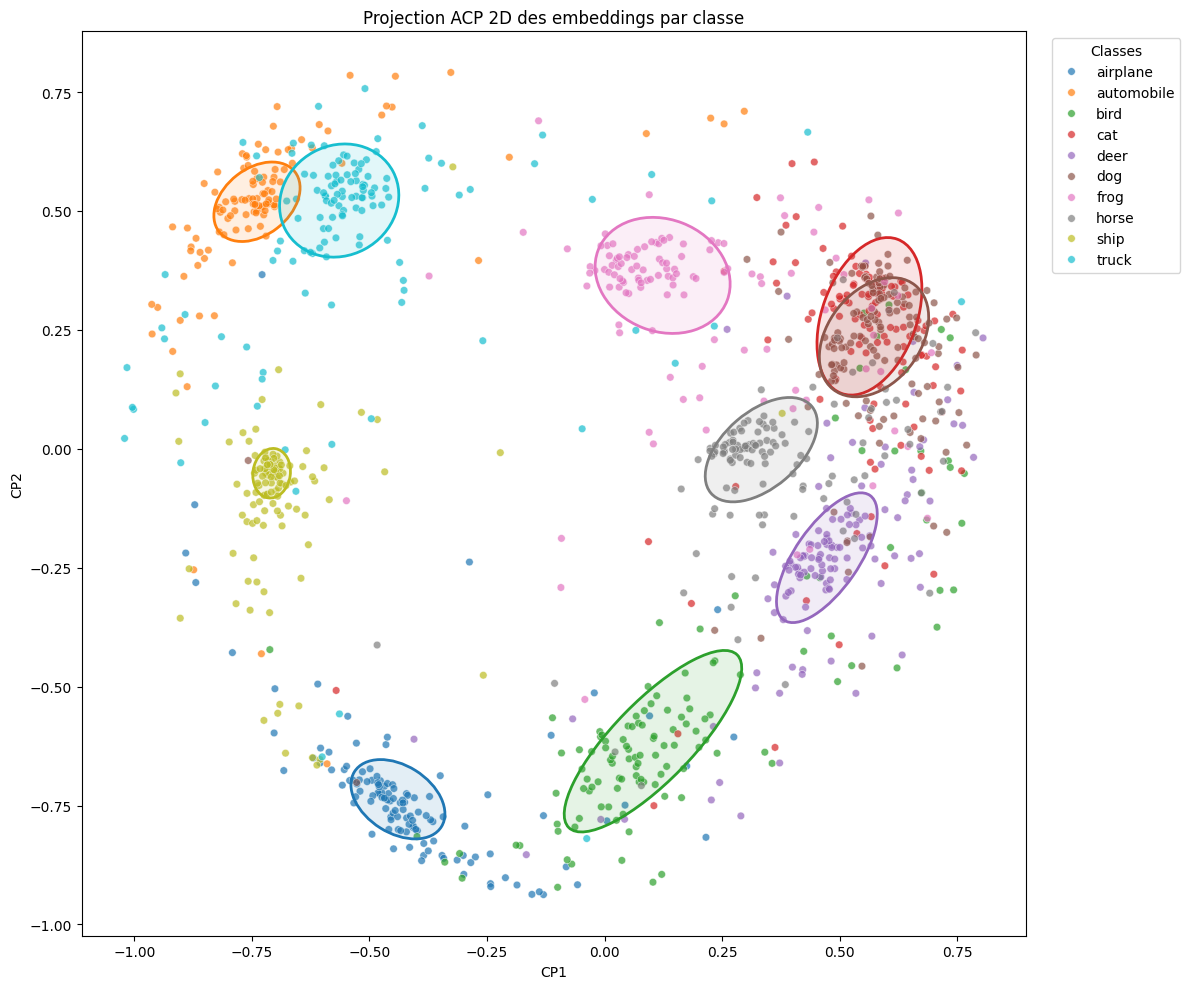

In [29]:
import pandas as pd
from matplotlib.patches import Ellipse

def plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    save_img_path,
):
    pca_2d_df = pd.DataFrame({
        'PC1': embeddings_2d[:, 0],
        'PC2': embeddings_2d[:, 1],
        'Label': labels_array,
        'Class': [label_names[int(label)] for label in labels_array]
    })

    fig, ax = plt.subplots(figsize=(12, 10))
    
    palette = sns.color_palette("tab10", n_colors=10)
    class_names = sorted(pca_2d_df['Class'].unique())
    color_map = {cls: palette[i] for i, cls in enumerate(class_names)}

    sns.scatterplot(
        data=pca_2d_df, x='PC1', y='PC2',
        hue='Class', palette=color_map,
        alpha=0.7, s=30, ax=ax
    )

    for cls in class_names:
        ep = ellipse_params[cls]
        center, w, h, angle = ep["center"], ep["width"], ep["height"], ep["angle"]
        color = color_map[cls]
        
        ellipse = Ellipse(
            xy=center, width=w, height=h, angle=angle,
            facecolor=(*color, 0.12), edgecolor=color, linewidth=2
        )
        ax.add_patch(ellipse)

    ax.set_xlabel('CP1')
    ax.set_ylabel('CP2')
    ax.set_title('Projection ACP 2D des embeddings par classe')
    ax.legend(title='Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(save_img_path, dpi=150, bbox_inches='tight')
    plt.show()


plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    save_img_path = save_dir / "embeddings_2d.png"
)

Le résultat dépend de la `seed` choisie. À moins d'exécuter exactement le même code (et avec la même `seed`), vous obtiendrez forcément une projection différente. Néanmoins, on retrouve généralement quelques tendances :
- *ship* et *airplane* ont les ellipses de plus petite aire, ce qui confirme l'analyse de la matrice de distances
- les points *cat* et *dog* sont proches, comme attendu
- autre confirmation de la matrice de distances : *automobile* et *deer* sont bien séparés, tout comme *bird* et *truck*.

Avant de terminer cet article, nous normalisons les coordonnées projetées entre 0 et 1, puis nous redessinons le plan. Cela nous servira ensuite à comparer plus facilement les valeurs entre expériences : paramètres des ellipses pour certaines classes, ainsi que la moyenne et la médiane de leurs aires.

Dans la suite, nous introduirons la *KoLeo loss*, qui aura un impact direct sur la répartition des embeddings et donc sur la taille des ellipses.


In [30]:
embeddings_2d = (embeddings_2d - embeddings_2d.min(axis=0)) / (embeddings_2d.max(axis=0) - embeddings_2d.min(axis=0))

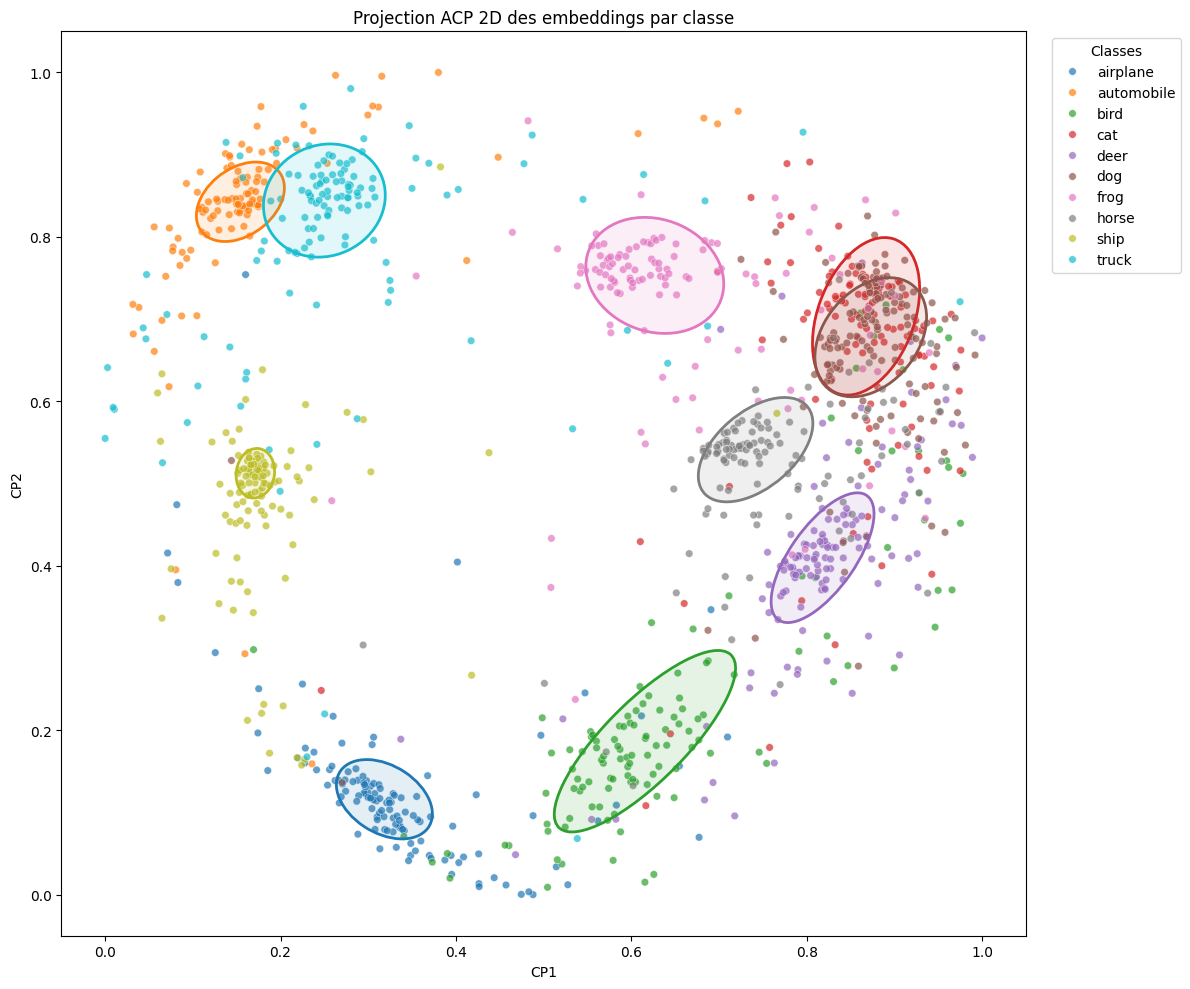

In [31]:
ellipse_params = get_ellipse_params_per_class(embeddings_2d, coverage)
plot_embeddings_with_ellipses(
    embeddings_2d=embeddings_2d,
    ellipse_params=ellipse_params,
    save_img_path = save_dir / "embeddings_2d_normalized.png"
)

In [32]:
mean_area = 0
for ep_dict in ellipse_params.values():
    area = np.pi * ep_dict["width"] * ep_dict["height"]
    ep_dict["area"] = area
    mean_area += area

In [33]:
for k, v in ellipse_params.items():
    if k in ["ship", "cat", "dog", "horse"]:
        print(f"Aire de l'ellipse de {k} = {v['area']:.4f}")

Aire de l'ellipse de cat = 0.0690
Aire de l'ellipse de dog = 0.0546
Aire de l'ellipse de horse = 0.0450
Aire de l'ellipse de ship = 0.0083


# Conclusion

Dans cet article, nous avons analysé les embeddings obtenus après l'entraînement d'un réseau siamois avec une *triplet loss* sur CIFAR‑10. Les résultats montrent une bonne séparation des classes dans l'espace des embeddings, et les confusions observées (*cat*/*dog*, *airplane*/*ship*) correspondent à des similarités visuelles réelles. La matrice de distances et la projection par ACP (PCA) avec les ellipses de confiance permettent de visualiser et de quantifier la compacité de chaque groupe.

Dans la suite de cette série, nous introduirons la *KoLeo loss* pour encourager une répartition plus uniforme des embeddings, et nous étudierons l'impact de l'accumulation de *gradient* sur cette régularisation dépendante du batch.